# 08. Random Forests

**Author:** [Your Name/GitHub Username]
**Date:** June 3, 2025

## Introduction

A **Random Forest** is an **ensemble learning** method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (for classification) or mean/average prediction (for regression) of the individual trees. It's a form of **bagging** (Bootstrap Aggregating) with an additional layer of randomness in feature selection during tree construction.

Random Forests are known for their high accuracy, robustness to overfitting (compared to individual decision trees), and ease of use.

* **Type:** Supervised Learning (Ensemble Method)
* **Task:** Classification and Regression
* **Goal:** To improve the predictive accuracy and control overfitting by combining the predictions of multiple decorrelated decision trees.

## Theoretical Background

### 1. Ensemble Learning
Ensemble learning combines multiple individual machine learning models (often called "weak learners" or "base estimators") to produce a more powerful and robust model ("strong learner"). The idea is that a diverse group of models, when combined, can lead to better performance than any single model.

### 2. Bagging (Bootstrap Aggregating)
Random Forests use bagging as a core technique:
1.  **Bootstrap Sampling:** Create $B$ different bootstrap samples from the original training dataset. Each bootstrap sample is created by randomly sampling $N$ instances from the original $N$ instances *with replacement*. This means some instances may appear multiple times in a sample, while others may not appear at all.
2.  **Model Training:** Train an independent decision tree on each of the $B$ bootstrap samples. These trees are typically grown deep (often without pruning).

Bagging helps to reduce the **variance** of the model without substantially increasing the bias.

### 3. Feature Randomness (Random Subspace Method)
In addition to bagging, Random Forests introduce another layer of randomness when growing the trees:
* When splitting a node during the construction of each tree, Random Forest considers only a **random subset of the features** instead of all available features.
* The number of features to consider at each split is a hyperparameter (often denoted as `max_features`). A common choice is $\sqrt{N_{features}}$ for classification and $N_{features}/3$ for regression.

This feature randomness helps to **decorrelate the trees** in the forest. If one or a few features are very strong predictors, they might be selected early in many trees in a standard bagging approach, leading to similar tree structures. By restricting the choice of features at each split, other features get a chance to contribute, making the trees more diverse. This further reduces variance and improves the model's robustness.

### 4. Prediction
* **For Classification:** Each tree in the forest makes a class prediction for a new instance. The Random Forest model outputs the class that receives the majority vote from the individual trees.
* **For Regression:** Each tree predicts a continuous value. The Random Forest model outputs the average of these predictions.

### 5. Out-of-Bag (OOB) Error/Score
Due to bootstrap sampling, each tree is trained on about two-thirds of the original training data. The remaining one-third of the data, not used in training that particular tree, are called **Out-of-Bag (OOB)** samples for that tree.
* For each instance in the original training set, we can use the trees for which it was an OOB sample to make a prediction.
* The OOB error is the average error rate (or other metric like accuracy) computed on these OOB predictions.
* This provides a convenient and unbiased estimate of the model's generalization performance without needing a separate validation set, though a test set is still crucial for final evaluation.

### 6. Feature Importance
Random Forests can estimate the importance of each feature. Common methods include:
* **Mean Decrease in Impurity (MDI):** For each feature, calculate the total reduction in the splitting criterion (e.g., Gini impurity or MSE) brought by splits on that feature, averaged over all trees in the forest. Features that lead to larger impurity reductions are considered more important.
* **Permutation Importance:** After training, the values of a single feature in the OOB samples (or a validation set) are randomly shuffled (permuted), and the decrease in model performance is measured. A larger drop indicates higher importance. This is generally considered more robust.

### 7. Key Hyperparameters
* `n_estimators`: The number of trees in the forest. More trees generally improve performance up to a point but increase computation time.
* `max_features`: The number of features to consider when looking for the best split at each node.
* `max_depth`: The maximum depth of each tree. Limiting depth can help prevent overfitting if individual trees are too complex.
* `min_samples_split`: The minimum number of samples required to split an internal node.
* `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
* `bootstrap`: Whether bootstrap samples are used when building trees (default is `True`).
* `oob_score`: Whether to use out-of-bag samples to estimate the generalization accuracy (default is `False`).

### Pros
* Generally high accuracy and robust performance.
* Less prone to overfitting compared to individual decision trees.
* Handles high-dimensional data well.
* Can handle missing values (though scikit-learn's implementation requires imputation beforehand).
* Provides useful estimates of feature importance.
* Requires little feature scaling as it's tree-based.
* Can compute an OOB error estimate internally.

### Cons
* Can be computationally intensive and require more memory than single decision trees, especially with a large number of trees and deep trees.
* Less interpretable than a single decision tree (it's a "black box" to some extent, though feature importances provide some insight).
* May not perform as well as highly tuned gradient boosting models on some specific tasks, but often a very strong baseline.

### Common Use Cases
* Wide range of classification and regression problems.
* Feature selection (using feature importance scores).
* Anomaly detection (though specialized methods might be better).
* Bioinformatics, finance, image analysis, etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler # Not strictly necessary for RF
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics # For accuracy, confusion matrix, classification report

# Set a style for seaborn plots
sns.set_style('whitegrid')

## Implementation with Python (Classification)

We'll use the **Breast Cancer Wisconsin dataset** for this classification example. It's a binary classification problem well-suited for demonstrating Random Forest.

In [2]:
from sklearn.datasets import load_breast_cancer

# Load the dataset
cancer_data = load_breast_cancer()

# Create a Pandas DataFrame for features and a Series for the target
X_df = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
y_s = pd.Series(cancer_data.target, name='Target') # 0 for malignant, 1 for benign
target_names = cancer_data.target_names

print("Features (X) - First 5 rows:")
print(X_df.head())
print(f"\nShape of features: {X_df.shape}")
print(f"\nTarget names: {target_names}")

Features (X) - First 5 rows:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  wo

In [3]:
# 1. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_s, test_size=0.3, random_state=42, stratify=y_s)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# 2. Feature Scaling (Discussion Point)
# Random Forests (and decision trees in general) are not sensitive to feature scaling
# because they make decisions based on thresholds for individual features.
# The scale of the feature does not affect the split point selection process.
# So, scaling is generally NOT required.

Training set size: 398
Testing set size: 171


In [4]:
# Create a Random Forest classifier instance
# Key hyperparameters:
# n_estimators: Number of trees in the forest
# max_features: Number of features to consider at each split (e.g., 'sqrt', 'log2', or an int/float)
# oob_score: Whether to use out-of-bag samples to estimate generalization accuracy
rf_classifier = RandomForestClassifier(
    n_estimators=100,       # Number of trees
    max_features='sqrt',    # Max features to consider for a split (sqrt(n_features))
    random_state=42,
    oob_score=True,         # Enable OOB score calculation
    n_jobs=-1               # Use all available CPU cores
)

# Fit the model
rf_classifier.fit(X_train, y_train)

print("Random Forest Classifier trained.")

# Access the OOB score
if rf_classifier.oob_score:
    print(f"\nOut-of-Bag (OOB) Score: {rf_classifier.oob_score_:.4f}")

Random Forest Classifier trained.

Out-of-Bag (OOB) Score: 0.9573


In [5]:
# Make predictions on the test set
y_pred_class = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test) # Probabilities for each class

# Display some predictions
predictions_df = pd.DataFrame({
    'Actual Target': y_test.values,
    'Predicted Class': y_pred_class,
    'Prob_Class_0 (Malignant)': y_pred_proba[:, 0],
    'Prob_Class_1 (Benign)': y_pred_proba[:, 1]
})
print("\nActual vs Predicted classes and Probabilities (first 10):")
print(predictions_df.head(10))


Actual vs Predicted classes and Probabilities (first 10):
   Actual Target  Predicted Class  Prob_Class_0 (Malignant)  \
0              0                0                      0.92   
1              1                1                      0.00   
2              1                1                      0.29   
3              0                0                      1.00   
4              0                1                      0.31   
5              0                0                      0.99   
6              1                1                      0.00   
7              0                0                      0.97   
8              1                1                      0.02   
9              0                0                      0.98   

   Prob_Class_1 (Benign)  
0                   0.08  
1                   1.00  
2                   0.71  
3                   0.00  
4                   0.69  
5                   0.01  
6                   1.00  
7                   0.03  
8   

### Model Evaluation Metrics (Classification)


Test Set Accuracy: 0.9357
Compare with OOB Score: 0.9573


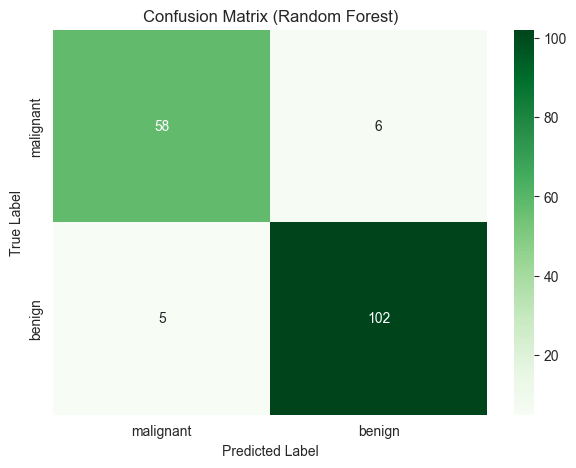


Classification Report:
              precision    recall  f1-score   support

   malignant       0.92      0.91      0.91        64
      benign       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



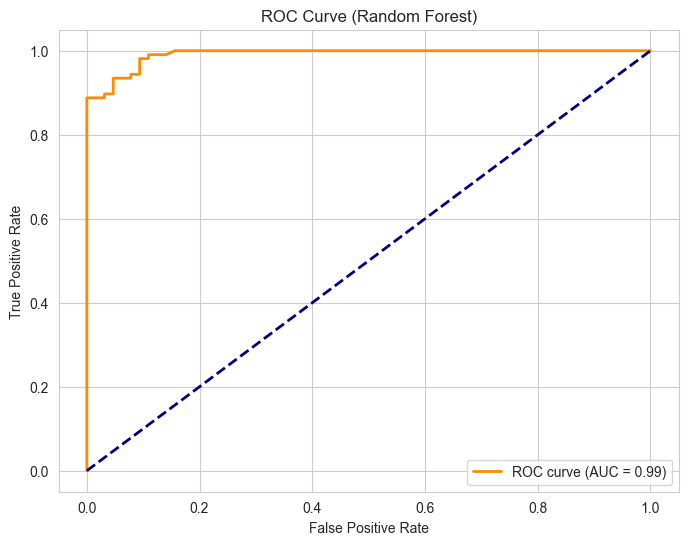

AUC Score: 0.9913


In [6]:
# 1. Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print(f"\nTest Set Accuracy: {accuracy:.4f}")
if rf_classifier.oob_score:
    print(f"Compare with OOB Score: {rf_classifier.oob_score_:.4f}")


# 2. Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. Classification Report
class_report = metrics.classification_report(y_test, y_pred_class, target_names=target_names)
print("\nClassification Report:")
print(class_report)

# 4. ROC Curve and AUC (Optional, but good for binary classification)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1]) # Probabilities of positive class (Benign=1)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc="lower right")
plt.show()
print(f"AUC Score: {roc_auc:.4f}")

### Feature Importance
Random Forests can provide an estimate of feature importance based on how much each feature contributes to reducing impurity (e.g., Gini impurity) across all trees.


Feature Importances from Random Forest:
                 Feature  Importance
27  worst concave points    0.158955
23            worst area    0.146962
22       worst perimeter    0.085793
20          worst radius    0.078952
0            mean radius    0.077714
2         mean perimeter    0.074234
7    mean concave points    0.065869
6         mean concavity    0.054281
3              mean area    0.041657
26       worst concavity    0.031362


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_53670/3808807227.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


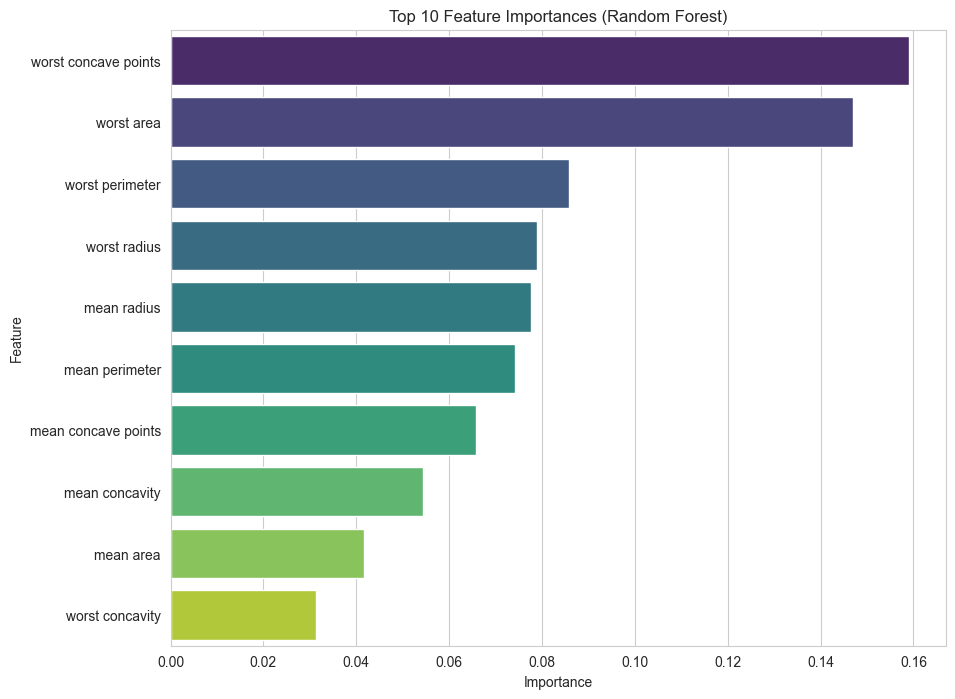

In [7]:
importances = rf_classifier.feature_importances_
feature_names = X_df.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances from Random Forest:")
print(feature_importance_df.head(10)) # Display top 10

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

## Hyperparameter Tuning (Brief)

Key hyperparameters like `n_estimators`, `max_features`, `max_depth`, `min_samples_split`, and `min_samples_leaf` can be tuned to optimize performance. `GridSearchCV` or `RandomizedSearchCV` are common tools.

* **`n_estimators`**: More trees usually mean better performance up to a point, but also longer training time. The OOB error can often be monitored to see when adding more trees stops providing significant benefit.
* **`max_features`**: Controls the diversity of trees. Lower values increase diversity but might lead to suboptimal individual trees.

Let's do a very small example with `GridSearchCV` for `n_estimators` and `max_depth`.
*(Note: A full grid search can be time-consuming)*

In [8]:
# Define a smaller parameter grid for a quick demo
param_grid_rf = {
    'n_estimators': [50, 100], # Number of trees
    'max_depth': [None, 10, 20],      # Max depth of trees
    'max_features': ['sqrt', 'log2']
}

# Create GridSearchCV object
# Using cv=3 for faster execution in this demo
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, oob_score=False, n_jobs=-1), # Disable OOB for grid search for speed
    param_grid_rf,
    cv=3,
    scoring='accuracy',
    verbose=1
)

# Fit GridSearchCV
# Consider using a subset of X_train for very large datasets to speed up demo
# grid_search_rf.fit(X_train.iloc[:100], y_train.iloc[:100]) # Example with subset
grid_search_rf.fit(X_train, y_train)


print("\nBest Parameters found by GridSearchCV (Random Forest):")
print(grid_search_rf.best_params_)
print(f"Best Cross-Validated Accuracy: {grid_search_rf.best_score_:.4f}")

# Evaluate the best model found by grid search on the test set
best_rf_classifier = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_classifier.predict(X_test)
accuracy_best_rf = metrics.accuracy_score(y_test, y_pred_best_rf)
print(f"Test Set Accuracy with Best Tuned Random Forest: {accuracy_best_rf:.4f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Parameters found by GridSearchCV (Random Forest):
{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}
Best Cross-Validated Accuracy: 0.9649
Test Set Accuracy with Best Tuned Random Forest: 0.9240


## Random Forests for Regression (Brief Example)

Random Forests can also be used for regression tasks. The principle is similar: multiple decision trees are built, and the final prediction is the average of the predictions from individual trees.


Random Forest Regression Evaluation:
Mean Squared Error (MSE): 0.2465
R-squared (R²): 0.5440
OOB Score (R²): 0.3573


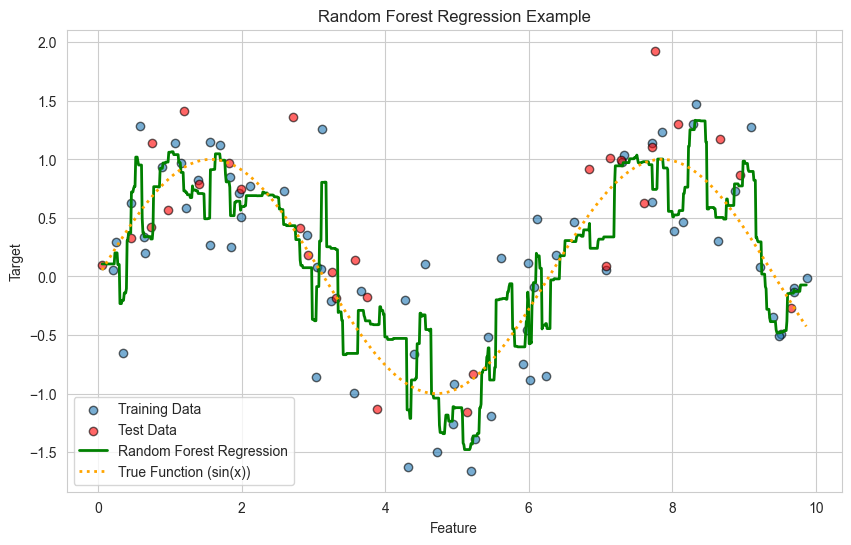

In [9]:
# Generate some simple 1D synthetic data for regression
np.random.seed(42)
X_reg = np.sort(10 * np.random.rand(100, 1), axis=0)
y_reg = np.sin(X_reg).ravel() + np.random.randn(100) * 0.5 # sin(x) + noise

# Split data
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True, n_jobs=-1)
rf_regressor.fit(X_reg_train, y_reg_train)

# Predictions
y_reg_pred = rf_regressor.predict(X_reg_test)

# Evaluation
mse_rf_reg = metrics.mean_squared_error(y_reg_test, y_reg_pred)
r2_rf_reg = metrics.r2_score(y_reg_test, y_reg_pred)
print(f"\nRandom Forest Regression Evaluation:")
print(f"Mean Squared Error (MSE): {mse_rf_reg:.4f}")
print(f"R-squared (R²): {r2_rf_reg:.4f}")
if rf_regressor.oob_score_:
    print(f"OOB Score (R²): {rf_regressor.oob_score_:.4f}")


# Plotting the results
X_plot_reg = np.arange(X_reg.min(), X_reg.max(), 0.01)[:, np.newaxis]
y_plot_pred_rf_reg = rf_regressor.predict(X_plot_reg)

plt.figure(figsize=(10, 6))
plt.scatter(X_reg_train, y_reg_train, alpha=0.6, edgecolor='k', label='Training Data')
plt.scatter(X_reg_test, y_reg_test, color='red', alpha=0.6, edgecolor='k', label='Test Data')
plt.plot(X_plot_reg, y_plot_pred_rf_reg, color='green', linewidth=2, label='Random Forest Regression')
plt.plot(X_plot_reg, np.sin(X_plot_reg), color='orange', linestyle=':', linewidth=2, label='True Function (sin(x))')
plt.title('Random Forest Regression Example')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()

## Conclusion & Key Takeaways

* Random Forests are powerful ensemble models that combine multiple decision trees using bagging and feature randomness.
* They generally provide high accuracy and are robust to overfitting compared to single decision trees.
* **Key mechanisms:** Bootstrap sampling of data (bagging) and random subspace selection of features for splits.
* **Feature scaling is generally not required.**
* Provide useful **feature importance** estimates and can calculate an **Out-of-Bag (OOB) error** for internal validation.
* Important hyperparameters include `n_estimators`, `max_features`, `max_depth`, etc., which can be tuned for optimal performance.
* Applicable to both classification and regression tasks with high effectiveness.

## Further Reading/References (Optional)

* [Scikit-learn RandomForestClassifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Scikit-learn RandomForestRegressor Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
* Original paper by Leo Breiman: ["Random Forests" (2001)](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)
* Chapter on Tree-Based Methods in "An Introduction to Statistical Learning" by James, Witten, Hastie, and Tibshirani.
* StatQuest: Random Forests, Clearly Explained.